In [34]:
import numpy as np
import seaborn as sb

In [279]:
def intervalo_confianza(lista):
    media = np.mean(lista)
    valor_z = 2.57
    desvio = np.std(lista)
    n = len(lista)
    
    ext_inferior = media - (valor_z * (desvio/(n ** 0.5)))
    ext_superior = media + (valor_z * (desvio/(n ** 0.5)))
    return ext_inferior, ext_superior

In [280]:
class Empleado():
    def __init__(self, tipo):
        if tipo == 1:
            self.nombre = "Empleado tipo 1"
            self.tiempoAtencion = round(np.random.normal(18,4)) #Normal de media 18 minutos y Desv.est. de 4 minutos.
        elif tipo == 2:
            self.nombre = "Empleado tipo 2"
            self.tiempoAtencion = round(np.random.exponential(15)) #Exponencial con tiempo promedio de 15 minutos. 
        elif tipo == 3:
            self.nombre = "Empleado tipo 3"
            self.tiempoAtencion = round(np.random.exponential(16)) #Exponencial con promedio de 16 minutos.
        elif tipo ==4:
            self.nombre = "Empleado tipo 4"
            self.tiempoAtencion = round(np.random.normal(14,3)) #Normal de media 14 minutos y desv.est. de 3 minutos.
        else:
            self.nombre = "Empleado tipo 5"
            self.tiempoAtencion = round(np.random.normal(19,5)) #Normal de media 19 minutos y desv.est. de 5 minutos.


In [281]:
class Camion():
    def __init__(self, id_camion):
        self.id = id_camion
        self.tiempoLlegada = round(np.random.exponential(15))
        self.tiempoInicioAtencion = -1
        
    def __repr__(self):
        return f"id: {self.id} - hora llegada: {self.tiempoLlegada} - hora en que fue atendido: {self.tiempoInicioAtencion}"

In [282]:
class Surtidor():
    def __init__(self, tipo):
        self.tipo = tipo
        self.ocupado = False
        self.tiempoOcupacion = 0
        self.tiempoAtencion = Empleado(tipo).tiempoAtencion
        
    def marcarLibre(self):
        self.ocupado = False
    
    def marcarOcupado(self):
        self.ocupado = True
    
    def actualizarPorcentajeOcupacion(self):
        self.tiempoOcupacion = self.tiempoOcupacion + self.tiempoAtencion
    
    def __str__(self):
        return f"{self.id}"

In [283]:
class Evento():
    """
    nombre = puede ser ARRIBO_CAMION, FIN_ATENCION
    objeto = puede ser un Camion o un Surtidor
    duracion = duracion del evento
    """
    def __init__(self, _id, nombre, objeto, arribo, duracion):
        self.id = _id
        self.nombre = nombre
        self.arribo = arribo
        self.duracion = duracion
        self.tiempo_fin = arribo + duracion
        self.objeto = objeto
        
    def __repr__(self):
        return f"{self.id} - {self.nombre} - arribo: {self.arribo} - duracion: {self.duracion} - termina: {self.tiempo_fin}\n"
    
    
class EventoFinAtencion(Evento):
    def __init__(self, evento_inicio, **kwargs):
        super(EventoFinAtencion, self).__init__(**kwargs)
        self.evento_inicio = evento_inicio
    
    def __repr__(self):
        return f"{self.id} - {self.nombre} a {self.evento_inicio.id} - inicia: {self.arribo} - duracion: {self.duracion} - termina: {self.tiempo_fin}\n"

In [577]:
def inicializarModelo(prefijo, cantidad_camiones, cantidad_surtidores):
    fel = []
    lista_surtidores = []
    for id_camion in range(cantidad_camiones): 
        camion = Camion(f"{prefijo}-C{id_camion}")
        fel.append(Evento(f"{prefijo}-C{id_camion}", 
                          "ARRIBO_CAMION",
                          camion,
                          camion.tiempoLlegada,
                          0))
    
    for i in range(cantidad_surtidores):
        lista_surtidores.append(Surtidor(i))
        
    return ordenarEventos(fel), lista_surtidores   

In [578]:
def haySurtidorLibre(lista_surtidores):
    return any(not surtidor.ocupado  for surtidor in lista_surtidores)

In [579]:
def getSurtidorLibre(lista_surtidores):
    for surtidor in lista_surtidores:
        if (not surtidor.ocupado):
            return surtidor

In [580]:
def ordenarEventos(fel):
    fel.sort(key=lambda evento: evento.arribo)
    return fel

In [581]:
def removerEvento(fel, evento): #remueve el siguiente evento de la FEL
    if evento in fel:
        fel.remove(evento)
    return fel #ordenarEventos(fel)

In [582]:
def agregarEvento(fel, evento): #agrega un nuevo evento y ordena la FEL
    fel.append(evento)
    return ordenarEventos(fel)

In [583]:
def calcularOcupacionSurtidores(lista_surtidores):
    resultado = []
    for surtidor in lista_surtidores:
        resultado.append(surtidor.tiempoOcupacion)
    return resultado

In [587]:
def simulacion(experimentos, corridas,camiones, surtidores):
    cant_experimentos = experimentos
    cant_corridas = corridas
    cant_camiones = camiones
    cant_surtidores = surtidores
    total_camiones = cant_experimentos*cant_corridas*cant_camiones
    contador = 0
    ocupacion_surtidores = {}
    demoras_promedio_experimento = []
    contador = 0
    
    for i in range(cant_experimentos):
        demora_promedio_corrida = []
        
        for j in range(cant_corridas):
            
            prefijo = f"{i}{j}" # un prefijo para identificar los eventos de cada experimento/corrida
            fel, lista_surtidores = inicializarModelo(prefijo, cant_camiones, cant_surtidores)
            lista = []
            k = 0 
            contador+=1
            
            while len(fel) > 0: #procesamos mientras la lista tenga eventos
                reloj_simulacion = 0
                evento = fel[k]
                reloj_simulacion += evento.arribo
                fel = removerEvento(fel, evento)
                if evento.nombre == "ARRIBO_CAMION":
                    if haySurtidorLibre(lista_surtidores):
                        surtidor = getSurtidorLibre(lista_surtidores)
                        surtidor.marcarOcupado()
                        surtidor.actualizarPorcentajeOcupacion()
                        evento_fin_atencion = EventoFinAtencion(evento_inicio=evento, #evento_inicio es el evento arribo relacionado al evento Fin de atencion
                                                                nombre="FIN_ATENCION", 
                                                                objeto=surtidor, 
                                                                _id=f"{prefijo}-F{k}",
                                                                arribo=reloj_simulacion, 
                                                                duracion=surtidor.tiempoAtencion) 
                        fel = agregarEvento(fel, evento_fin_atencion)
                        demora = abs(evento.arribo - evento_fin_atencion.duracion) #calculamos la demora en atender a este camion.
                        demora_promedio_corrida.append(demora)
                        #evento.objeto.tiempoInicioAtencion = reloj_simulacion # como fue atendido, seteamos este atributo al camion.    

                
                if evento.nombre == "FIN_ATENCION":
                    evento.objeto.marcarLibre()
                    #evento.objeto.actualizarPorcentajeOcupacion()
                    evento_inicio = evento.evento_inicio #evento_inicio sirve para quitar ambos eventos (arribo y espera) de la FEL
                    fel = removerEvento(fel, evento_inicio)
               
                fel = removerEvento(fel, evento)
                k += 1
                if k >= len(fel):
                    if len(fel) > 0: # siguen habiendo eventos por procesar, reseteamos k.
                        k = 0 
                    else:
                        break
            ocupacion_surtidores[contador] = calcularOcupacionSurtidores(lista_surtidores)

        demoras_promedio_experimento.append(np.mean(demora_promedio_corrida))     
    return demoras_promedio_experimento, ocupacion_surtidores

In [588]:
#import datetime
#print(datetime.datetime.now().time())
demoras_promedio_experimento, ocupacion_surtidores = simulacion(experimentos=60, corridas=100, camiones=(24*60), surtidores=4)
#print(datetime.datetime.now().time())

### Demora Promedio de los camiones

In [589]:
print(f"Demora promedio {np.mean(demoras_promedio_experimento):.2f}")

Demora promedio 13.50


### Intervalo de confianza con un nivel de confiabilidad del 99%.

In [590]:
intervalo_confianza(demoras_promedio_experimento)

(13.316653482529242, 13.673770376068417)

### Histograma de la simulación (tiempos promedio por cada experimento).

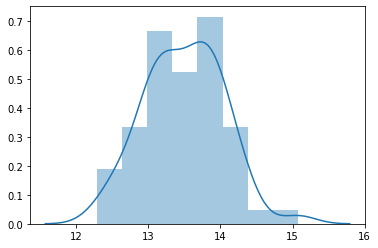

In [591]:
grafico = sb.distplot(demoras_promedio_experimento)

### Grafico de barras con tiempos de espera para todos los experimentos

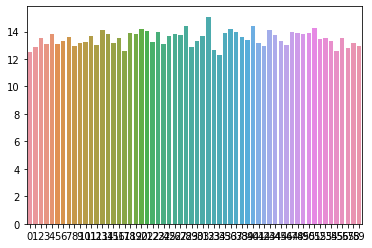

In [592]:
lista = [x for x in range(len(demoras_promedio_experimento))]
ax = sb.barplot(x=lista, y=demoras_promedio_experimento)

### Calcule el porcentaje de tiempo de ocupación de cada surtidor.

In [593]:
ocupacion_surtidor1 = 0
ocupacion_surtidor2 = 0
ocupacion_surtidor3 = 0
ocupacion_surtidor4 = 0
cantidad_corridas = 60 * 100 * 60 * 24

for k,v in ocupacion_surtidores.items():
    ocupacion_surtidor1 = v[0] + ocupacion_surtidor1 
    ocupacion_surtidor2 = v[1] + ocupacion_surtidor2 
    ocupacion_surtidor3 = v[2] + ocupacion_surtidor3 
    ocupacion_surtidor4 = v[3] + ocupacion_surtidor4 

print("Ocupacion surtidor 1")
print(str(round(((ocupacion_surtidor1*100)/cantidad_corridas),2))+"%")
print("Ocupacion surtidor 2")
print(str(round(((ocupacion_surtidor2*100)/cantidad_corridas),2))+"%")
print("Ocupacion surtidor 3")
print(str(round(((ocupacion_surtidor3*100)/cantidad_corridas),2))+"%")
print("Ocupacion surtidor 4")
print(str(round(((ocupacion_surtidor4*100)/cantidad_corridas),2))+"%")

Ocupacion surtidor 1
12.2%
Ocupacion surtidor 2
10.97%
Ocupacion surtidor 3
9.04%
Ocupacion surtidor 4
9.09%


### Realice la simulación pero esta vez, añadiendo un nuevo surtidor cuyo empleado tenga una capacidad de atención Normal (media = 19 min, desvío = 5 min.) y analice los resultados. ¿Los camiones pasan menos tiempo en espera?

In [594]:
demoras_promedio_experimento, ocupacion_surtidores = simulacion(experimentos=60, corridas=100, camiones=(24*60), surtidores=5)

### Resultado con un 5to surtidor agregado

### Demora Promedio de los camiones

In [595]:
print(f"Demora promedio {np.mean(demoras_promedio_experimento):.2f}")

Demora promedio 12.79


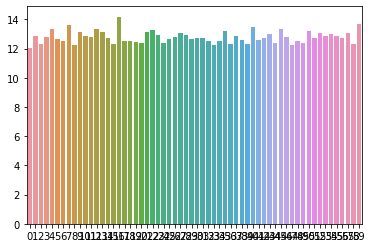

In [596]:
lista = [x for x in range(len(demoras_promedio_experimento))]
ax = sb.barplot(x=lista, y=demoras_promedio_experimento)

Este resultado me indica que el promedio de espera de los camiones es menor que en la situacion anterior en la que tenia solo 4 surtidores disponibles.

### Calcule la cantidad necesaria de surtidores y sus características de atención*, para disminuir el tiempo de espera en un 30%.

Tomando en cuenta que el tiempo de espera de los clientes en promedio es de 3748.64 reducirlo en un 30%
implicaria que el promedio de espera queda en un valor aproximado de 2624.048. Realizando una regla de 3 si
con 4 maquinas obtengo un promedio de 3748.64 entonces necesitaria aproximadamente 4 maquinas mas.